In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot
from keras import backend as K
from keract import get_activations, display_activations
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.crossover.sbx import SBX
from pymoo.core.problem import Problem, ElementwiseProblem
import pandas as pd
import random as rng

In [2]:
# Preparing the mnist dataset
num_classes = 10
input_shape = (28, 28, 1)

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [3]:
# Building the model

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

In [4]:
# Training the model

batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15
422/422 [==============================] - 9s 19ms/step - loss: 0.3649 - accuracy: 0.8891 - val_loss: 0.0783 - val_accuracy: 0.9780
Epoch 2/15
422/422 [==============================] - 8s 18ms/step - loss: 0.1132 - accuracy: 0.9655 - val_loss: 0.0655 - val_accuracy: 0.9817
Epoch 3/15
422/422 [==============================] - 8s 18ms/step - loss: 0.0854 - accuracy: 0.9735 - val_loss: 0.0486 - val_accuracy: 0.9877
Epoch 4/15
422/422 [==============================] - 8s 18ms/step - loss: 0.0714 - accuracy: 0.9777 - val_loss: 0.0428 - val_accuracy: 0.9865
Epoch 5/15
422/422 [==============================] - 8s 18ms/step - loss: 0.0633 - accuracy: 0.9802 - val_loss: 0.0384 - val_accuracy: 0.9892
Epoch 6/15
422/422 [==============================] - 8s 18ms/step - loss: 0.0558 - accuracy: 0.9825 - val_loss: 0.0363 - val_accuracy: 0.9903
Epoch 7/15
422/422 [==============================] - 8s 18ms/step - loss: 0.0503 - accuracy: 0.9847 - val_loss: 0.0358 - val_accuracy: 0.9897

In [23]:
# score = model.evaluate(x_test, y_test, verbose=0)

### NAC Implementation 1 ###

# nodes = 0
# non_zero_nodes = 0

# for n in range(0, len(model.layers)):
#     get_nth_layer_output = K.function([model.layers[0].input], [model.layers[n].output])
#     layer_output = get_nth_layer_output([x_test])[0]
#     nodes += layer_output.size
#     non_zero_nodes += np.count_nonzero(layer_output)


# neuron_coverage = non_zero_nodes / nodes

# print("Neuron coverage:", neuron_coverage)

### NAC Implementation 2 ###

def Neuron_Activation_Coverage(model, input_img):
    
    if len(input_img.shape) < 4:
        input_img = np.expand_dims(input_img, axis=0)

    activations = get_activations(model, input_img, auto_compile=True)
    del activations["input_1"]

    total_nodes = 0
    non_zeros = 0
    for value in activations.values():
        total_nodes += value.size
        non_zeros += np.count_nonzero(value)

    return non_zeros / total_nodes

nac = Neuron_Activation_Coverage(model, x_test[0])

print("NAC: ", nac)


NAC:  0.2943627822397333


In [6]:
# Problem class for NSGA
class NCMax(ElementwiseProblem):
    def __init__(self, input_img):
        super().__init__(
            n_var=784, n_obj=1, n_constr=3, xl=0.0, xu=1.0)
        self.input_img = input_img
    
    def _evaluate(self, x, out, *args, **kwargs):
        x = np.reshape(x, (28, 28, 1))
        perturbed_img = self.input_img + x
        nc = Neuron_Activation_Coverage(model, perturbed_img)
        ret_val = 1.0 / nc
        out["F"] = ret_val
        constr1 = np.sum(np.abs(x)) - 80.0
        constr2 = np.sqrt(np.sum(np.square(x))) - 5.0
        constr3 = x.max() - 0.8
        out["G"] = np.column_stack([constr1, constr2, constr3])

alg = NSGA2(pop_size = 100, offsprings=100,
            sampling=FloatRandomSampling(),
            crossovers=SBX(),
            mutation=PolynomialMutation(),)

challenging_images = np.zeros(shape=(10000, 28, 28, 1))

random_indexes = rng.sample(range(0, 10000), 100)

# Applying NSGA to images / a random image
for i in range(0, 1):
    problem = NCMax(x_test[random_indexes[i]])
    
    res = minimize(problem, alg, ("n_gen", 200), least_feasible_solution=False, save_history=True)
    if res.X.size > 784:                             # Sometimes the result object contains more than one element, if that's the case we simply pick one of them.
        noise = np.reshape(res.X[0], (28, 28, 1))
    else:
        noise = np.reshape(res.X, (28, 28, 1))

    challenging_img = x_test[random_indexes[i]] + noise
    challenging_images[i] = challenging_img

x_test_nacs = []
challenging_images_nacs = []
absolute_increase = []
relative_increase = []

# Calculates NAC for image(s) pre and post nsga
for i in range(0, 1):
    pre_NSGA = Neuron_Activation_Coverage(model, x_test[random_indexes[i]])
    post_NSGA = Neuron_Activation_Coverage(model, challenging_images[i])
    x_test_nacs.append(pre_NSGA)
    challenging_images_nacs.append(post_NSGA)
    absolute_increase.append(post_NSGA - pre_NSGA)
    relative_increase.append((post_NSGA - pre_NSGA) / pre_NSGA) 
    

In [8]:
# Converts data to a more readable format
dataset = {
    "Normal Images": x_test_nacs,
    "Challenging Images": challenging_images_nacs,
    "Absolute Increase": absolute_increase,
    "Relative Increase": relative_increase
}

table = pd.DataFrame(dataset)
print(table)
# table.index += 1

# table.to_excel("temp.xlsx")

   Normal Images  Challenging Images  Absolute Increase  Relative Increase
0       0.302041            0.454917           0.152877           0.506146


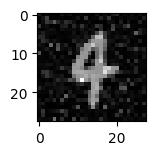

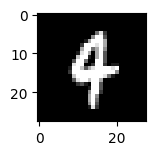

In [9]:
# Post NSGA image
pyplot.subplot(330 + 1)
pyplot.imshow(challenging_images[0], cmap=pyplot.get_cmap('gray'))
pyplot.show()

# Pre NSGA image
pyplot.subplot(330 + 1)
pyplot.imshow(x_test[random_indexes[0]], cmap=pyplot.get_cmap('gray'))
pyplot.show()